In [80]:
from pathlib import Path
import random

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms

from segmentation.datasets import Slides, ImageFolder, SemiSupervisedDataLoader
from segmentation.instances import DiscriminativeLoss, mean_shift, visualise_embeddings, visualise_instances
from segmentation.network import SemanticInstanceSegmentation
from segmentation.training import train

In [93]:
transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomCrop((256, 768)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()])

target_transform = transforms.Compose([transform, transforms.Lambda(lambda x: (x * 255).long())])

batch_size = 3

# WARNING: Don't use multiple workers for loading! Doesn't work with setting random seed
train_data_labelled = Slides(download=True, train=True, root='data', transform=transform, target_transform=target_transform)
train_loader_labelled = torch.utils.data.DataLoader(train_data_labelled, batch_size=batch_size, drop_last=True, shuffle=True)
train_data_unlabelled = ImageFolder(root='data/slides', transform=transform)
train_loader_unlabelled = torch.utils.data.DataLoader(train_data_unlabelled, batch_size=batch_size, drop_last=True, shuffle=True)
train_loader = SemiSupervisedDataLoader(train_loader_labelled, train_loader_unlabelled)

test_data_labelled = Slides(download=True, train=False, root='data', transform=transform, target_transform=target_transform)
test_loader_labelled = torch.utils.data.DataLoader(test_data_labelled, batch_size=batch_size, drop_last=True, shuffle=True)
test_data_unlabelled = ImageFolder(root='data/slides', transform=transform)
test_loader_unlabelled = torch.utils.data.DataLoader(test_data_unlabelled, batch_size=batch_size, drop_last=True, shuffle=True)
test_loader = SemiSupervisedDataLoader(test_loader_labelled, test_loader_unlabelled)

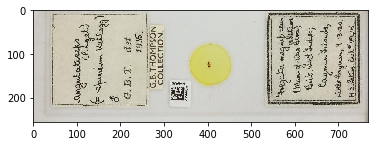

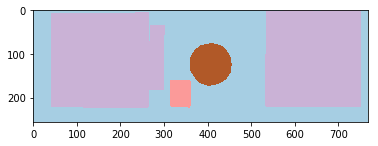

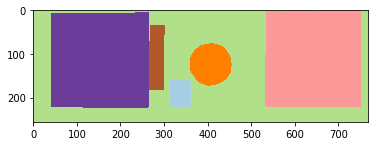

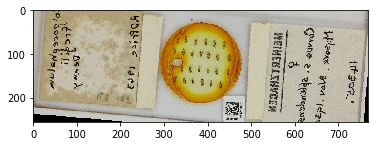

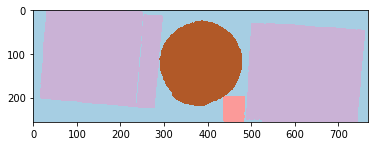

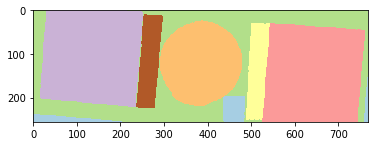

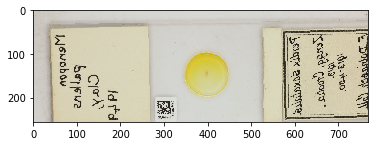

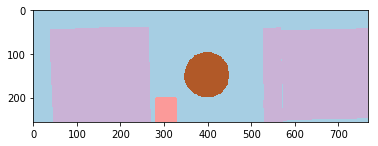

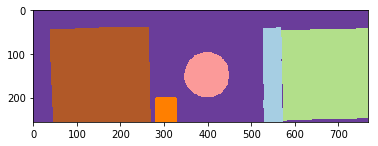

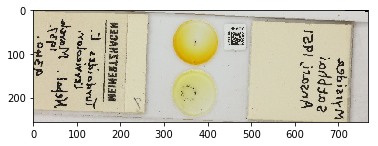

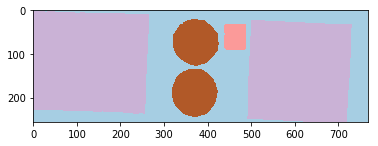

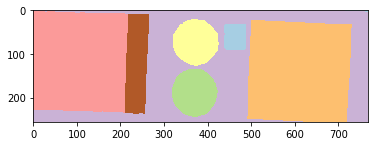

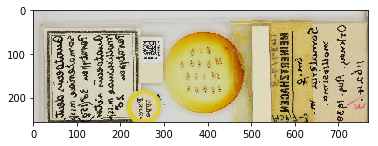

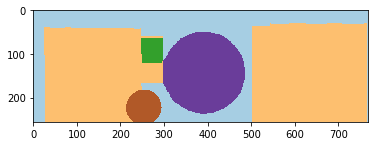

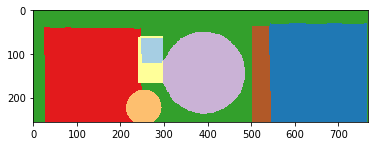

In [100]:
for i in range(len(train_loader.labelled.dataset)):
    if i > 10:
        training_data=train_loader.labelled.dataset[i]
        image, labels, instances = training_data
        image, labels, instances = Variable(image.unsqueeze(0)), Variable(labels.unsqueeze(0)), Variable(instances)
        # only to see images when debugging
        # see the slide
        plt.imshow(image.data[0].cpu().numpy().transpose(1,2,0))
        plt.show()
        # see the labels
        plt.imshow(labels[0,0])
        plt.show()
        # see instances
        plt.imshow(instances.cpu().numpy().squeeze())
        plt.show()
    if i == 15:
        break
        

In [90]:
train_loader = torch.utils.data.DataLoader(train_data_labelled, batch_size=1, shuffle=True)

image, labels, instances = next(iter(train_loader))
image = Variable(image)
instances = Variable(instances + 1)
current_labels = labels[0, 0]
current_instances = instances[0]


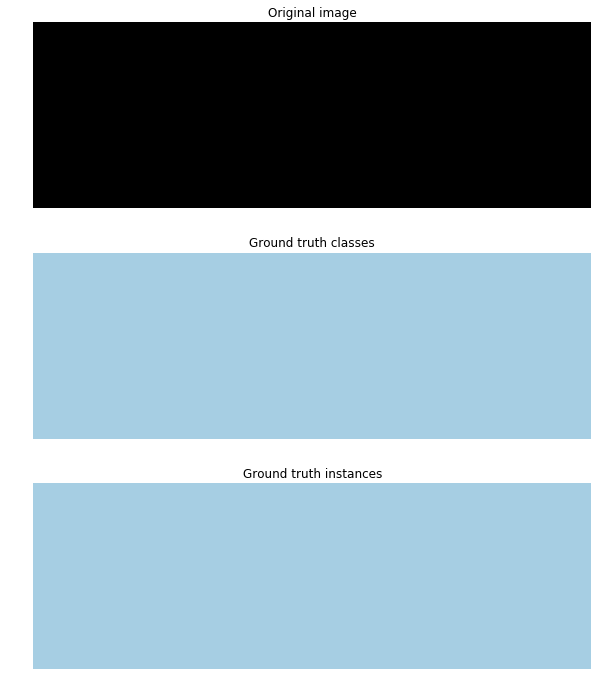

In [92]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
for ax in axes.flatten(): ax.axis('off')

axes[0].set_title('Original image')
axes[0].imshow(image[0].data.numpy().transpose(1, 2, 0))
axes[1].set_title('Ground truth classes')
axes[1].imshow(current_labels.cpu().numpy().squeeze())
axes[2].set_title('Ground truth instances')
axes[2].imshow(current_instances.cpu().numpy().squeeze())